In [ ]:
!pip install -q pymorphy3
!pip install -q gensim
!pip install -q gudhi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 904.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 20.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 46.8 MB/s et

In [ ]:
from gudhi.clustering.tomato import Tomato
from scipy.spatial.distance import cosine
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import pickle
import numpy as np
import random
import torch
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy3 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import DataCollatorForLanguageModeling, BertTokenizer, BertForMaskedLM, Trainer, TrainingArguments, BertModel
from gensim.models import Word2Vec, FastText
from chardet.universaldetector import UniversalDetector

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

Для начала обучим модель Word2Vec на одном из корпусов (Я выбрал "russian love story")

# Tokenize russian_love_story.txt

In [ ]:
def has_english(s: str) -> bool:
    return any(c.isalpha() and c.isascii() for c in s)


def preprocess_text(
    text: str,
    language: str = 'russian',
    lemmatize: bool = True,
    remove_stopwords: bool = True,
    min_word_length: int = 2,
    extra_stopwords: list = None
) -> list:
    """
    Предобрабатывает текст для NLP-задач.

    Параметры:
        text (str): Исходный текст
        language (str): Язык текста ('russian' или 'english')
        lemmatize (bool): Применять лемматизацию
        remove_stopwords (bool): Удалять стоп-слова
        min_word_length (int): Минимальная длина сохраняемых слов
        extra_stopwords (list): Дополнительные стоп-слова

    Возвращает:
        list: Список обработанных токенов
    """
    try:
        # Инициализация инструментов
        morph = MorphAnalyzer() if lemmatize and language == 'russian' else None
        stop_words = set(stopwords.words(language)) if remove_stopwords else set()

        # Добавление дополнительных стоп-слов
        if extra_stopwords:
            stop_words.update(extra_stopwords)

        # Очистка текста
        text = text.lower()
        text = re.sub(r'[^a-zа-яё\s]', ' ', text, flags=re.IGNORECASE)  # Удаление пунктуации и цифр
        text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов

        # Токенизация
        tokens = word_tokenize(text, language=language)

        # Обработка токенов
        processed_tokens = []
        for token in tokens:
            # Удаление коротких слов
            if len(token) < min_word_length:
                continue

            # Лемматизация
            if lemmatize and morph:
                lemma = morph.parse(token)[0].normal_form
                token = lemma

            # Удаление стоп-слов
            if remove_stopwords and token in stop_words:
                continue

            if has_english(token):
                continue

            processed_tokens.append(token)

        return processed_tokens

    except LookupError as e:
        print(f"Ошибка: {e}. Проверьте установку необходимых ресурсов nltk.")
        return []
    except Exception as e:
        print(f"Неизвестная ошибка: {e}")
        return []

In [ ]:
output = []
with open("data/tokens_for_love_story_correct.txt", encoding="utf-8") as f:
    for line in f:
        output += line.strip().split(", ")
tokens = []
for word in output:
  tokens.append(word[1:len(word) - 1])
sentences = []
sentences.append(tokens)

In [ ]:
len(tokens)

2265229

In [ ]:
word2vec_model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4
)

In [ ]:
word2vec_model.save(os.path.join('models', 'word2vec.model'))

In [ ]:
# Load the model (if needed)
model = Word2Vec.load("models/word2vec.model")

In [ ]:
def similar_words(word: str):
  similar_words = model.wv.most_similar(word, topn=5)
  print(f"Most similar words to {word}:", similar_words)

Посмотрим на результаты обучения модели: приведём в пример списки ближайших соседей для некоторых токенов.

In [ ]:

# Similarity between two words
try:
    similarity_human_man = model.wv.similarity('человек', 'мужчина')
    print(f"Similarity between 'человек' and 'мужчина': {similarity_human_man:.4f}")
except KeyError as e:
    print(f"KeyError: {e}")

# Most similar words to 'мужчина'
try:
    similar_words('человек')
    similar_words('еда')
    similar_words('женщина')

except KeyError as e:
    print(f"KeyError: {e}")

# Perform an analogy task
try:
    analogy_result = model.wv.most_similar(positive=['мужчина', 'женщина'], negative=['ребёнок'], topn=1)
    print("Analogy result for 'мужчина + женщина - ребёнок':", analogy_result)

    analogy_result = model.wv.most_similar(positive=['мужчина', 'молодой'], topn=3)
    print("Analogy result for 'мужчина + молодой':", analogy_result)
except KeyError as e:
    print(f"KeyError: {e}")

Similarity between 'человек' and 'мужчина': 0.1377
Most similar words to человек: [('невесело', 0.22244606912136078), ('просто', 0.22091180086135864), ('филин', 0.21220694482326508), ('гризли', 0.21006052196025848), ('расставляться', 0.20991280674934387)]
Most similar words to еда: [('натурщица', 0.21820852160453796), ('ревностно', 0.2153216451406479), ('сладкий', 0.20609009265899658), ('чертяка', 0.2048344612121582), ('заступник', 0.19904325902462006)]
Most similar words to женщина: [('степ', 0.2627282738685608), ('снеговик', 0.23378615081310272), ('штампик', 0.22945283353328705), ('врезать', 0.22869661450386047), ('опускаться', 0.2271985560655594)]
Analogy result for 'мужчина + женщина - ребёнок': [('вторичный', 0.23264919221401215)]
Analogy result for 'мужчина + молодой': [('толкиен', 0.22556792199611664), ('внучонок', 0.22517859935760498), ('плёнка', 0.22313480079174042)]


# Reduce Dimensionality using PCA

Попытаемся визуализировать наше вложение, используя метод сокращения размерности PCA

In [ ]:
word_vectors = model.wv[model.wv.index_to_key]
X_data = word_vectors

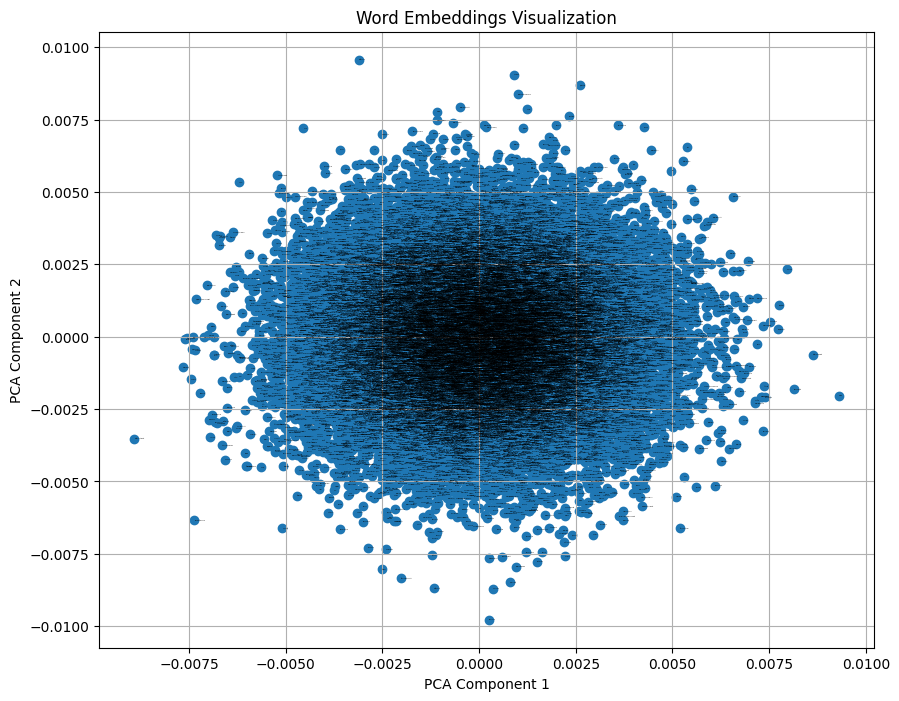

In [ ]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.decomposition import PCA


word_number = int(X_data.shape[0])
# Reduce dimensionality of word vectors for visualization
word_vectors = model.wv[model.wv.index_to_key[:word_number]]  # Get the word vectors
pca = PCA(n_components=2)  # Initialize PCA
result = pca.fit_transform(word_vectors)  # Fit and transform the word vectors

# Plot the words in a 2D space
plt.figure(figsize=(10, 8))
plt.scatter(result[:, 0], result[:, 1])

# Annotate words in the plot
words = list(model.wv.index_to_key)[:word_number]
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=0)

plt.title("Word Embeddings Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

Заметим, что слова образуют "кучную" область. Попробуем провести кластеризацию

# KMeans clastering
Попробуем для начала разбить данные на 2 кластера

In [ ]:
def KMeans_clastering_with_pca(data):
  num_clusters = 2
  word_number = int(data.shape[0] / 5)
  kmeans = KMeans(n_clusters=num_clusters, n_init=5, max_iter=500, random_state=42)
  kmeans.fit(data[:word_number])

  sentence = words[:word_number]
  results = pd.DataFrame()
  results['document'] = sentence
  results['cluster'] = kmeans.labels_

  print(results.sample(5))

  reduced_data = result[:word_number]

  colors = ['red', 'green']
  cluster_labels = ['label_1', 'label_2']
  for i in range(num_clusters):
    plt.scatter(reduced_data[kmeans.labels_ == i, 0],
    reduced_data[kmeans.labels_ == i, 1],
    s=10, color=colors[i],
    label=f'{cluster_labels[i]}')

  plt.legend()
  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.title('K-Means Clustering of Love_Story words')
  plt.show()

         document  cluster
4864       сессия        1
3014    счастливо        1
1702  направление        0
6451         приз        0
7356       зубной        0


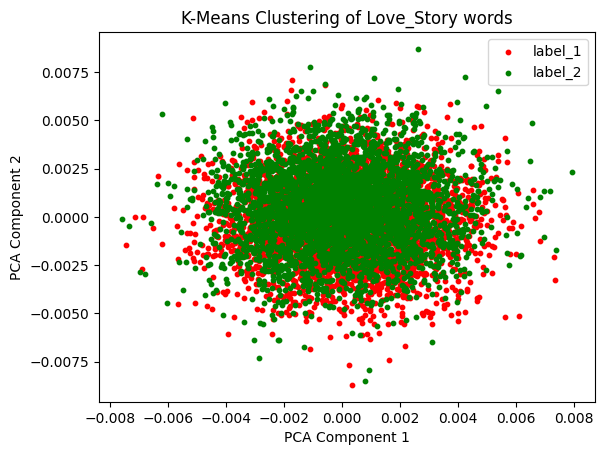

In [ ]:
KMeans_clastering_with_pca(X_data)

# KMeans after PCA

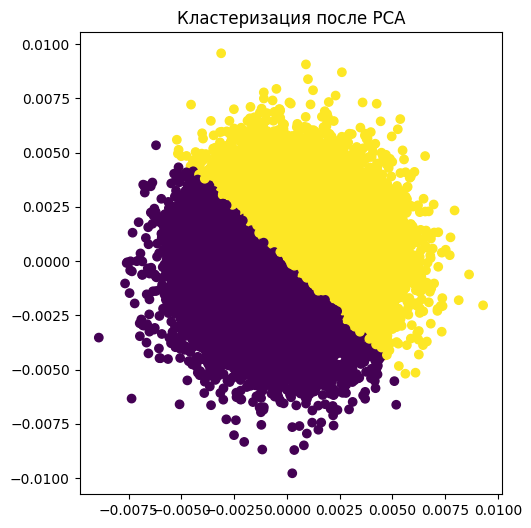

In [ ]:
kmeans_pca = KMeans(n_clusters=2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_data)
y_pred_pca = kmeans_pca.fit_predict(X_pca)

plt.figure(figsize=(12, 6))
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_pca, cmap='viridis')
plt.title("Кластеризация после PCA")
plt.show()

Видно, что результаты операций:
"Сначала кластеризация, затем сокращение размерности" и
"Сокращение размерности, затем кластеризация" сильно отличаются.

Теперь попробуем использовать размеченный файл со словосочетаниями: для каждого прилагательного рассмотрим вложения только тех существительных, которые встречаются с ним в словосочетаниях.

In [ ]:
import pickle
with open('data/saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [ ]:
adj = list(loaded_dict.keys())[0]
len(list(loaded_dict[adj].keys()))

194

In [ ]:
data = loaded_dict
counter = 0
for adj in tqdm(data.keys()):
  for word in data[adj].keys():
    counter += 1
print(f"\ncounter={counter}")


100%|██████████| 99/99 [00:00<00:00, 27033.60it/s]


counter=19930


In [ ]:
data = loaded_dict
model = Word2Vec.load("models/word2vec.model")
not_found_counter = 0
for adj in tqdm(data.keys()):
    for word in data[adj].keys():
        try:
            vector = model.wv[word]
            vector = vector / np.linalg.norm(vector)
            data[adj][word]['wor2vec'] = vector
        except:
            print(f"Слово {word} не найдено")
            not_found_counter += 1
print(f"\nnot found words: {not_found_counter}")

In [ ]:
with open("data/embeddings_dict.pkl", "wb") as f:
    pickle.dump(data, f)

In [ ]:
with open("data/word2vec_vectors.pkl", "wb") as f:
    pickle.dump(X_data, f)

In [ ]:
adj_list = list(loaded_dict.keys())
loaded_dict.keys()

dict_keys(['крупный', 'горячий', 'серый', 'легкий', 'известный', 'чужой', 'голый', 'детский', 'единственный', 'равный', 'советский', 'лучший', 'мокрый', 'общий', 'веселый', 'далекий', 'полный', 'синий', 'золотой', 'желтый', 'долгий', 'важный', 'большой', 'собственный', 'дорогой', 'высокий', 'небольшой', 'близкий', 'поздний', 'глубокий', 'быстрый', 'железный', 'старый', 'красный', 'женский', 'главный', 'скорый', 'хороший', 'свободный', 'милый', 'страшный', 'странный', 'новый', 'бывший', 'готовый', 'чистый', 'последний', 'теплый', 'зеленый', 'великий', 'русский', 'серьезный', 'целый', 'низкий', 'ночной', 'настоящий', 'молодой', 'плохой', 'обычный', 'военный', 'правый', 'следующий', 'уверенный', 'маленький', 'спокойный', 'родной', 'человеческий', 'прекрасный', 'нужный', 'огромный', 'широкий', 'белый', 'старший', 'сильный', 'пустой', 'тяжелый', 'левый', 'ясный', 'простой', 'тонкий', 'красивый', 'добрый', 'короткий', 'длинный', 'холодный', 'живой', 'подобный', 'разный', 'счастливый', 'интер

In [ ]:
import seaborn as sns
CONFIG = {
    'homology_dims': (0, 1),
    'results_dir': 'giotto_results',
    'visualization': {
        'style': 'whitegrid',
        'palette': 'muted',
        'figsize': (12, 6)
    }
}

CONFIG.update({
    'data_dims': 5,  # Исходная размерность данных
    'proj_method': 'pca',  # pca, tsne, или None
    'max_viz_dims': 3  # Максимум 3 для 3D-визуализации
})

for dir_path in [CONFIG['results_dir'], 'visualizations']:
    os.makedirs(dir_path, exist_ok=True)


def visualize_high_d(data, title_suffix):
    """Универсальная визуализация для любых размерностей"""
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    # Проекция данных
    if data.shape[1] > CONFIG['max_viz_dims']:
        if CONFIG['proj_method'] == 'pca':
            proj = PCA(n_components=2).fit_transform(data)
            label = 'PCA проекция'
        elif CONFIG['proj_method'] == 'tsne':
            proj = TSNE(n_components=2).fit_transform(data)
            label = 't-SNE проекция'
        else:
            raise ValueError("Неверный метод проекции")
    else:
        proj = data
        label = 'Исходные данные'

    # Визуализация
    plt.figure(figsize=(10, 6))

    if proj.shape[1] == 3:
        from mpl_toolkits.mplot3d import Axes3D
        ax = plt.subplot(111, projection='3d')
        ax.scatter(
            proj[:, 0],
            proj[:, 1],
            proj[:, 2],
            c=sns.color_palette("hsv", proj.shape[0]),
            s=40
        )
    else:
        sns.scatterplot(
            x=proj[:, 0],
            y=proj[:, 1],
            hue=np.linalg.norm(data, axis=1),
            palette='viridis',
            s=50
        )

    plt.title(f'{label} | {title_suffix}')
    plt.savefig(f"visualizations/{title_suffix}.png", dpi=150)
    plt.close()

In [ ]:
def show_distribution_for_nouns(adj):
  nouns = []
  for noun in loaded_dict[adj].keys():
    nouns.append(loaded_dict[adj][noun]['wor2vec'])
  X_nouns = np.array(nouns)

  visualize_high_d(X_nouns, f"Nouns for {adj}, всего их {len(list(loaded_dict[adj].keys()))} штук")

In [ ]:
for adj in adj_list[3:8]:
  show_distribution_for_nouns(adj)

In [ ]:
visualize_high_d(X_data[:200], "расположение первых 200 слов")

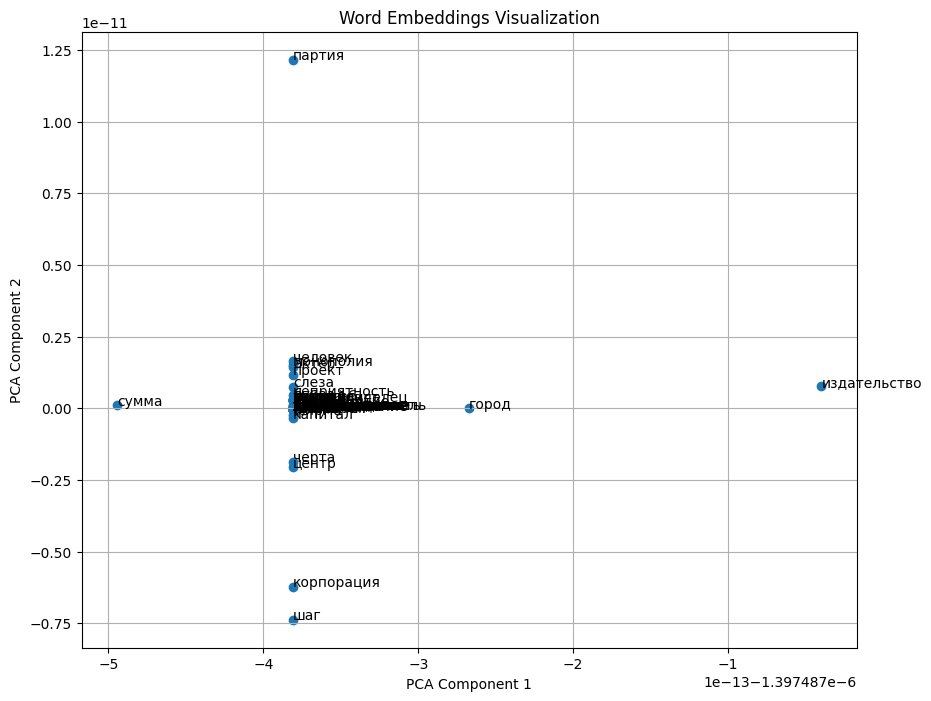

In [ ]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

adj = 'крупный'
nouns = []
for noun in loaded_dict[adj].keys():
  nouns.append(loaded_dict[adj][noun]['wor2vec'])
X_nouns = np.array(nouns)


# Reduce dimensionality of word vectors for visualization
word_vectors = X_nouns  # Get the word vectors
pca = PCA(n_components=2)  # Initialize PCA
result = pca.fit_transform(word_vectors)  # Fit and transform the word vectors

# Plot the words in a 2D space
plt.figure(figsize=(10, 8))
plt.scatter(result[:, 0], result[:, 1])

# Annotate words in the plot
words = list(loaded_dict[adj].keys())
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=10)

plt.title("Word Embeddings Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

Так относительно друг друга располагаются существительные, которые встречаются в словосочетаниях с прилагательным "крупный". Заметим, что практически все существительные, кроме небольшого числа, лежат достаточно близко друг к другу.

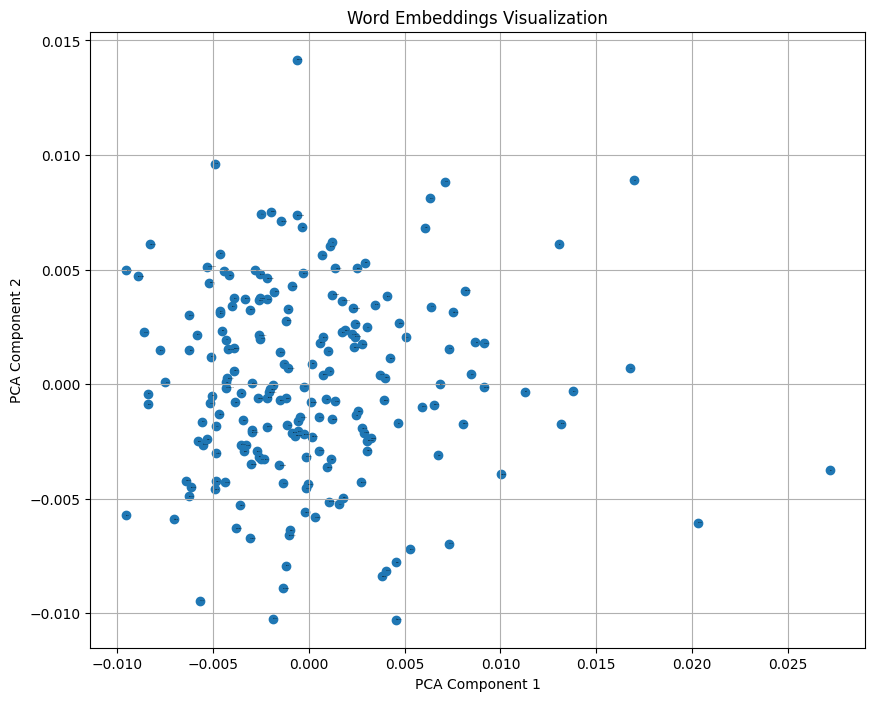

In [ ]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.decomposition import PCA


word_number = 200
# Reduce dimensionality of word vectors for visualization
word_vectors = model.wv[model.wv.index_to_key[:word_number]]  # Get the word vectors
pca = PCA(n_components=2)  # Initialize PCA
result = pca.fit_transform(word_vectors)  # Fit and transform the word vectors

# Plot the words in a 2D space
plt.figure(figsize=(10, 8))
plt.scatter(result[:, 0], result[:, 1])

# Annotate words in the plot
words = list(model.wv.index_to_key)[:word_number]
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=0)

plt.title("Word Embeddings Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

In [ ]:
len(loaded_dict.keys())

99

In [ ]:
word_vectors = model.wv[model.wv.index_to_key]
X_data = word_vectors

num_clusters = len(loaded_dict.keys())
kmeans = KMeans(n_clusters=num_clusters, n_init=5, max_iter=500, random_state=42)
kmeans.fit(X_data)
sentence = list(model.wv.index_to_key)

results = pd.DataFrame()
results['document'] = sentence
results['cluster'] = kmeans.labels_

In [ ]:
dict_clustering = dict()
for i in range(len(sentence)):
  dict_clustering[sentence[i]] = kmeans.labels_[i]

In [ ]:
len(words)

200

In [ ]:
adj = 'крупный'
nouns = []
for noun in loaded_dict[adj].keys():
  nouns.append(loaded_dict[adj][noun]['wor2vec'])
X_nouns = np.array(nouns)

In [ ]:
clasters_numbers = list()
for noun in loaded_dict[adj].keys():
  if noun in dict_clustering.keys():
    clasters_numbers.append(dict_clustering[noun])


In [ ]:
len(set(clasters_numbers))

79

Получается, что количество различных кластеров, в которых находятся существительные, относящиеся к одному прилагательному, очень велико, чего по нашему предположению быть не должно.

Попробуем применить кластеризацию ToMaTo


In [ ]:
from gudhi.clustering.tomato import Tomato
from scipy.spatial.distance import cosine

clusterization = Tomato(metric=cosine, density_type='KDE', k=2, kde_params={'algorithm': 'ball_tree', 'metric': 'pyfunc', 'metric_params': {'func': cosine}})
clusterization.fit(X_data)

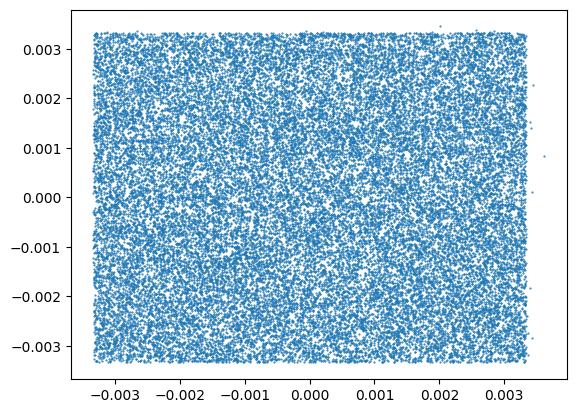

In [ ]:
plt.scatter(X_data[:,0],X_data[:,1],marker='.',s=1)
plt.show()

In [ ]:
def cluster_and_save(data, k, output_dir="clusters"):
    os.makedirs(output_dir, exist_ok=True)

    for adj in tqdm(data.keys()):
        for model_name in ['wor2vec']:
            vectors = []
            words = []

            for noun, models in data[adj].items():
                vector = models.get(model_name)
                if vector is not None and not np.allclose(vector, 0):
                    vectors.append(vector)
                    words.append(noun)

            try:
                clusterization = Tomato(
                    metric=cosine,
                    density_type='logKDE',
                    k=k,
                    kde_params={'algorithm': 'ball_tree', 'metric': 'pyfunc', 'metric_params': {'func': cosine}}
                )

                clusterization.fit(vectors)
                labels = clusterization.labels_

                cluster_words = defaultdict(list)
                for word, label in zip(words, labels):
                    if label == -1:
                        continue
                    cluster_words[label].append(word)

                filename = f"{output_dir}/{adj}_{model_name}_clusters.txt"
                with open(filename, "w", encoding="utf-8") as f:
                    f.write(f"Number of clusters: {len(cluster_words)}\n\n")
                    for cluster_id, words in cluster_words.items():
                        f.write(f"### Cluster {cluster_id} ({len(words)} words)\n")
                        f.write(", ".join(sorted(words)))
                        f.write("\n\n")
            except Exception as e:
                print(f"Ошибка для {adj}-{model_name}: {str(e)}")

In [ ]:
import pickle

with open("data/embeddings_dict.pkl", "rb") as f:
    data = pickle.load(f)

cluster_and_save(data, 4)

100%|██████████| 99/99 [01:30<00:00,  1.09it/s]
